# Title: Development Patterns of Iskandar Puteri
# Introduction
The development of a city or region is a complex process shaped by various factors, including demographic changes, economic conditions, and government policies. Understanding the patterns of development is crucial for planning and decision-making. In this study, the aim is to uncover hidden development patterns in Iskandar Puteri using clustering algorithms on geospatial data. Through this analysis, we hope to gain a deeper understanding of the area’s development patterns and provide insights for future planning and decision-making


## Dataset
The dataset in this project comprises geometric information from OpenStreetMap, a free and editable map of the world created and maintained by a global community of volunteers. The data was obtained using the OSMnx package, a python library for downloading and working with OpenStreetMap data. The data includes information about roads, buildings, and other features and can be used for any purpose as long as credit is given to OpenStreetMap. OpenStreetMap data is commonly used in web-based mapping applications, routing software, and GIS software and by various organisations and individuals for various purposes. The specific geographic data used in this project was obtained for the location of Iskandar Puteri.

## Research Questions
What are the hidden development patterns in Iskandar Puteri?
- [ANSWER](#4b-observe-pattern-of-development)

## Conceptual framework for approaching the research question
- Step 1: Get data within Iskandar Puteri area
- Step 2: Divide into grids
- Step 3: Count terms in each grid box
- Step 4: Clustering by using terms count as features
- Step 5: Cluster interpretation

<div>
<img src="img/Slide1.PNG" width="250"/>
<img src="img/Slide2.PNG" width="250"/>
<img src="img/Slide3.PNG" width="250"/>
<img src="img/Slide4.PNG" width="250"/>
<img src="img/Slide5.PNG" width="250"/>
<img src="img/Slide6.PNG" width="250"/>
</div>

## Methodology
1. [Data Preparation & Cleaning](#1-data-preparation--cleaning)
    - [A. Data Download](#1a-data-download)
    - [B. Initial Data Structure (EDA 1)](#1b-exploratory-data-analysis-eda-of-data-structure)
    - [C. Data Cleaning 1](#1c-data-cleaning)
    - [D. Data Content/Meaning (EDA 2)](#1d-eda-for-data-contentmeaning)
    - [E. Data Cleaning 2](#1e-data-cleaning)
2. [Feature Engineering](#2-feature-engineering)
    - [A. Calculate Centroid](#2a-calculate-centroid)
    - [B. Merge Data](#2b-merge-data)
    - [C. Get Bounding Boxes in the Grid](#2c-get-data-bounding-box)
    - [D. Count Terms in Bounding Boxes](#2d-count-occurence-of-term-in-each-bounding-box)
3. [Clustering](#3-clustering)
    - [A. DBSCAN Clustering Grid Search](#3a-grid-search-for-dbscan-clustering)
    - [B. Model Selection](#3b-select-model)
    - [C. Clusters Visualisation](#3c-clusters-visualisation)
4. [Interpretation](#4-cluster-interpretation)
    - [A. Clusters Word Cloud](#4a-visualize-the-terms-in-the-clusters-by-word-cloud)
    - [B. Pattern of development](#4b-observe-pattern-of-development)
5. [Conclusion](#5-conclusion)


## System Requirements
1. Python 3.10
2. GeoPandas
3. OSMnx
4. Matplotlib
5. Contextily
6. Scikit-Learn
7. Numpy

# Packages Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
import osmnx as ox
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle,Patch
from matplotlib import colors
from itertools import combinations
from math import floor, ceil
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize,minmax_scale,robust_scale

# 1. Data Preparation & Cleaning
## 1A. Data Download
Dataset was downloaded using OSMnx API. The dataset consist of geospatial geometries of buildings, amenities, leisures, and shops.

In [2]:
## download data from Open Street Map
PLACE_NAME = "Iskandar Puteri"
# building = ox.geometries_from_place(PLACE_NAME,{"building":True})
# amenity = ox.geometries_from_place(PLACE_NAME,{"amenity":True})
# leisure = ox.geometries_from_place(PLACE_NAME,{"leisure":True})
# shop = ox.geometries_from_place(PLACE_NAME,{"shop":True})
# area = ox.geocode_to_gdf(PLACE_NAME)

building_file = "data/iskandar_puteri.building"
amenity_file = "data/iskandar_puteri.amenity"
leisure_file = "data/iskandar_puteri.leisure"
shop_file = "data/iskandar_puteri.shop"
area_file = "data/iskandar_puteri.area"

files = [building_file,amenity_file,leisure_file,shop_file,area_file]

## This extra step saving files into pickle is 
## to reduce time because redownloading takes a long time.
## This step only executed once. next time only need to 
## use the saved pickle.

# def save_pickle_file(file,geom):
#     with open(file ,"wb") as f:
#         pickle.dump(geom,f)

# geoms = [building,amenity,leisure,shop,area]
# for file,geom in zip(files,geoms):
#     save_pickle_file(file,geom)

## reload pickle from saved file
def load_pickle_file(file):
    with open(file, "rb") as f:
        return pickle.load(f)

building,amenity,leisure,shop,area = [load_pickle_file(file) for file in files]

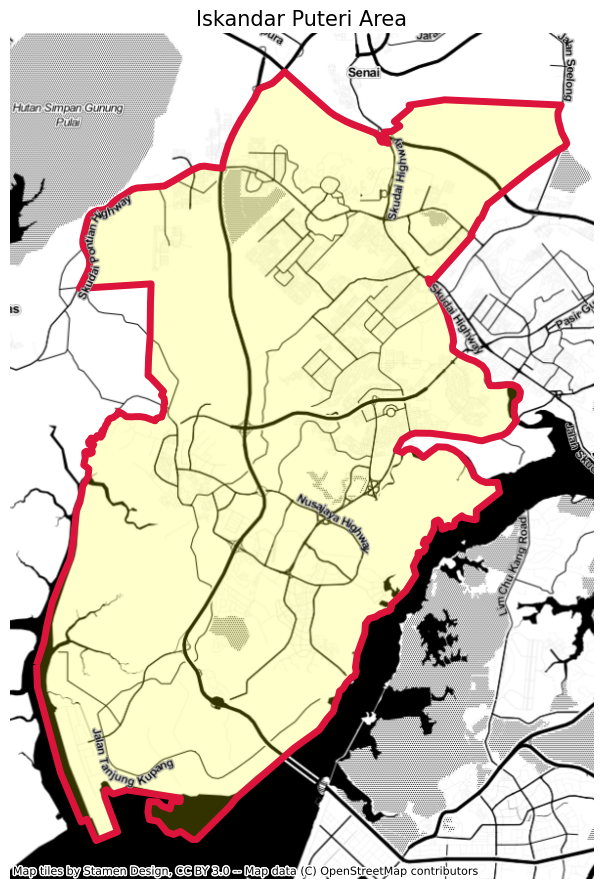

In [3]:
fig, ax = plt.subplots(figsize=(7,9))
# draw iskandar puter boundary
area.boundary.to_crs('EPSG:32648').plot(ax=ax,edgecolor='crimson',linewidth=5)
area.to_crs('EPSG:32648').plot(ax=ax,color='yellow',alpha=0.2)
# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerBackground, crs='EPSG:32648')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLabels, crs='EPSG:32648')
ax.axis("off")
plt.title("Iskandar Puteri Area",fontsize=15)
plt.tight_layout()
plt.show()

## 1B. Exploratory Data Analysis (EDA) of Data Structure

In [4]:
type(building),type(amenity),type(leisure),type(shop),type(area)

(geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame)

In [5]:
# dimensions of original data
building.shape,amenity.shape,leisure.shape,shop.shape,area.shape

((21369, 126), (1358, 133), (468, 51), (546, 89), (1, 14))

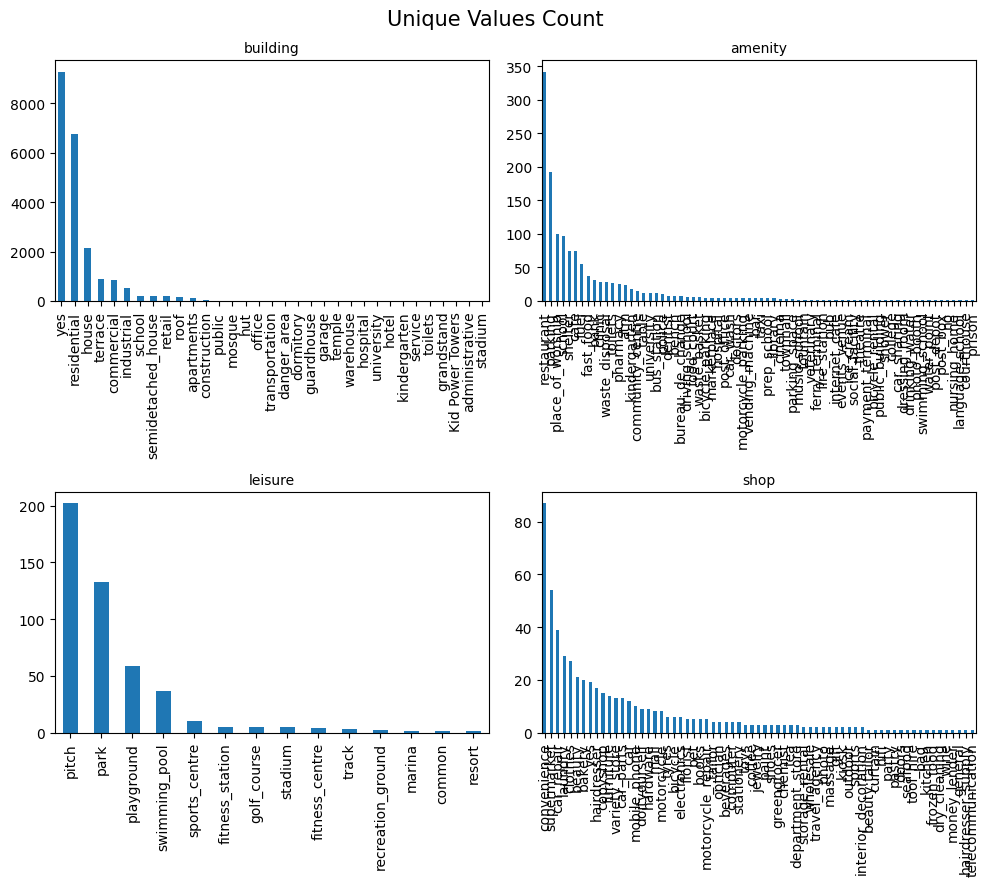

In [6]:
geom_ents = [building.building,amenity.amenity,leisure.leisure,shop.shop]
titles = ['building','amenity','leisure','shop']
fig,ax = plt.subplots(2,2,figsize=(10,9))
for i,(geom_ent,title) in enumerate(zip(geom_ents,titles)):
    row,col = i//2,i%2
    geom_ent.value_counts().plot(kind='bar',ax=ax[row,col])
    ax[row,col].set_title(title,fontsize=10)
plt.suptitle("Unique Values Count",fontsize=15)
plt.tight_layout()
plt.show()

C:\Users\elvin\AppData\Local\Temp\ipykernel_15320\1520674701.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area.centroid[0].xy[0][0] - 0.015,
C:\Users\elvin\AppData\Local\Temp\ipykernel_15320\1520674701.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area.centroid[0].xy[1][0],


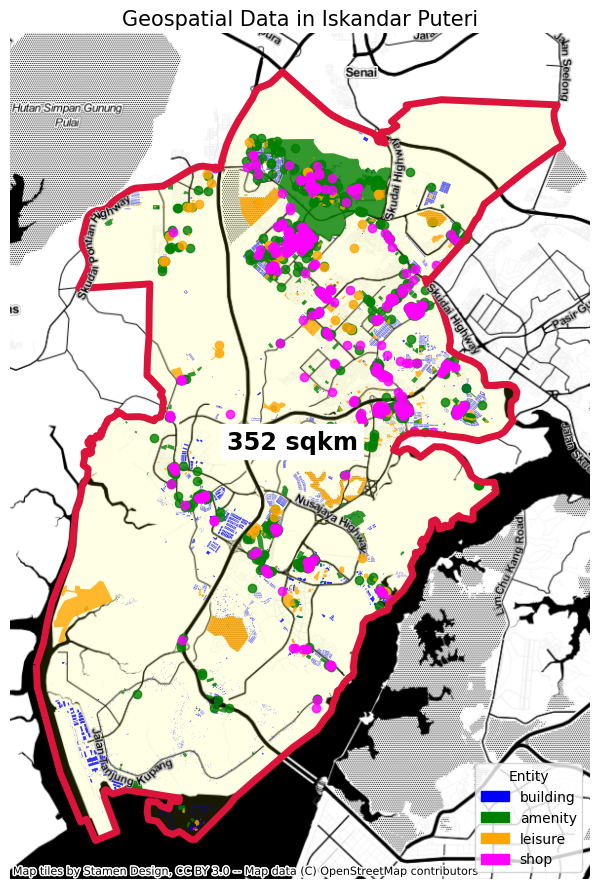

In [7]:
geoms = [building,amenity,leisure,shop]
titles = ['building','amenity','leisure','shop']
colors = ['blue','green','orange','magenta']
fig,ax = plt.subplots(figsize=(7,9))
area.plot(ax=ax,color='yellow',alpha=0.1)
for geom,title,color in zip(geoms,titles,colors):
    geom.plot(ax=ax,facecolor=color,color=color,alpha=0.8)

legend_elements = [Patch(color=c,label=t) for t,c in  zip(titles,colors)]
ax.legend(title="Entity", handles=legend_elements, loc='lower right')

plt.title("Geospatial Data in Iskandar Puteri",fontsize=15)
# draw iskandar puter boundary
area.boundary.plot(ax=ax,edgecolor='crimson',linewidth=5)
# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerBackground, crs='EPSG:4326')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLabels, crs='EPSG:4326')
ax.axis("off")
# displaying the area in sqkm
plt.text(
    area.centroid[0].xy[0][0] - 0.015,
    area.centroid[0].xy[1][0],
    f"{round(area.to_crs('EPSG:32648').area[0]/1_000_000)} sqkm",
    va='center',
    fontsize='xx-large',
    backgroundcolor='white',
    fontweight='black')
plt.tight_layout()
plt.show()

## 1C. Data Cleaning

Drop all unnecessary columns

In [8]:
print("Before:",building.shape,amenity.shape,leisure.shape,shop.shape)
building = building.dropna(axis=1)
amenity = amenity.dropna(axis=1)
leisure = leisure.dropna(axis=1)
shop = shop.dropna(axis=1)
print("After:",building.shape,amenity.shape,leisure.shape,shop.shape)

Before: (21369, 126) (1358, 133) (468, 51) (546, 89)
After: (21369, 2) (1358, 2) (468, 2) (546, 2)


In [9]:
# check if data have common index format
print(list(building.index.get_level_values(0).unique()))
print(list(amenity.index.get_level_values(0).unique()))
print(list(leisure.index.get_level_values(0).unique()))
print(list(shop.index.get_level_values(0).unique()))

['node', 'way', 'relation']
['node', 'way', 'relation']
['node', 'way', 'relation']
['node', 'way', 'relation']


## 1D. EDA for Data Content/Meaning

### Are there repeating OSMID ?
Repeating osmid need to be identified and later removed.

In [10]:
# shorthand for osmid indexes for readability reason
buil_i = building.index.get_level_values(1)
amen_i = amenity.index.get_level_values(1)
leis_i = leisure.index.get_level_values(1)
shop_i = shop.index.get_level_values(1)
# total number of item in each variables
print(f"{len(buil_i)= }\n{len(amen_i)= }\n{len(leis_i)= }\n{len(shop_i)= }")

len(buil_i)= 21369
len(amen_i)= 1358
len(leis_i)= 468
len(shop_i)= 546


In [11]:
# count number of intersection (same value) for all combinations of sets
for i,j in list(combinations([("building",buil_i),("amenity",amen_i),("leisure",leis_i),("shop",shop_i)],2)):
    print(f"How many {j[0]: <7} in {i[0]: <8} ? {len(i[1].intersection(j[1])): <3} out of {len(i[1])} {i[0]}")

How many amenity in building ? 141 out of 21369 building
How many leisure in building ? 4   out of 21369 building
How many shop    in building ? 55  out of 21369 building
How many leisure in amenity  ? 0   out of 1358 amenity
How many shop    in amenity  ? 4   out of 1358 amenity
How many shop    in leisure  ? 0   out of 468 leisure


### What are the node,way, & relation ?
Elements are the basic components of OpenStreetMap's conceptual data model of the physical world. Elements are of three types:

- nodes (defining points in space),
- ways (defining linear features and area boundaries), and
- relations (which are sometimes used to explain how other elements work together).

For this purpose we assume node, way, and relation are completely separate entity. Therefore one osmid considered to be one item.

In [12]:
pd.concat((building.reset_index().groupby('element_type')[['osmid']].count(),
amenity.reset_index().groupby('element_type')[['osmid']].count(),
leisure.reset_index().groupby('element_type')[['osmid']].count(),
shop.reset_index().groupby('element_type')[['osmid']].count()),axis=1)

,osmid,osmid,osmid,osmid
element_type,,,,
node,8,911,41,493
relation,45,1,1,1
way,21316,446,426,52


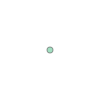

In [13]:
# Example of building node
building.loc['node'].iloc[0].geometry

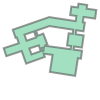

In [14]:
# Example of building relation
building.loc['relation'].iloc[0].geometry

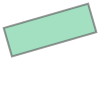

In [15]:
# Example of building way
building.loc['way'].iloc[0].geometry

### Are there any same values between building, amenity, leisure, shop?
If there are, should they be removed?

In [16]:
# show unique values
buil_val = building.building.unique()
amen_val = amenity.amenity.unique()
leis_val = leisure.leisure.unique()
shop_val = shop.shop.unique()
print(f"{len(buil_val)= }\n{len(amen_val)= }\n{len(leis_val)= }\n{len(shop_val)= }")

len(buil_val)= 33
len(amen_val)= 70
len(leis_val)= 14
len(shop_val)= 67


In [17]:
# count number of intersection (same value) for all combinations of sets

for i,j in list(combinations([("building",buil_val),("amenity",amen_val),("leisure",leis_val),("shop",shop_val)],2)):
    print(f"How many {j[0]: <7} in {i[0]: <8} ? {len(np.intersect1d(i[1],j[1]))} out of {len(i[1])} {i[0]}")

How many amenity in building ? 5 out of 33 building
How many leisure in building ? 1 out of 33 building
How many shop    in building ? 1 out of 33 building
How many leisure in amenity  ? 0 out of 70 amenity
How many shop    in amenity  ? 0 out of 70 amenity
How many shop    in leisure  ? 0 out of 14 leisure


In [18]:
print("What are amenity in building?",list(np.intersect1d(buil_val,amen_val)))
print("What are leisure in building?",list(np.intersect1d(buil_val,leis_val)))
print("What are shop in building?",list(np.intersect1d(buil_val,shop_val)))

What are amenity in building? ['hospital', 'kindergarten', 'school', 'toilets', 'university']
What are leisure in building? ['stadium']
What are shop in building? ['yes']


because we found 'yes' in both building & shop we need to replace to 'building' or 'shop' respectively.

## 1E. Data Cleaning
Remove same osmid. Rule: remove from the bigger set.

In [19]:
# reset indexes to simplify process
building = building.reset_index()
amenity = amenity.reset_index()
leisure = leisure.reset_index()
shop = shop.reset_index()

In [20]:
# we found 'yes' similar in both building & shop
# Therefore, we need to change to 'building' or 'shop' instead.
building['building'].replace({'yes':'building'},inplace=True)
shop['shop'].replace({'yes':'shop'},inplace=True)
# remove 141 amenities from building
criteria = ~building['osmid'].isin(buil_i.intersection(amen_i))
building = building[criteria]
# remove 4 leisure rom building
criteria = ~building['osmid'].isin(buil_i.intersection(leis_i))
building = building[criteria]
# remove 55 shop rom building
criteria = ~building['osmid'].isin(buil_i.intersection(shop_i))
building = building[criteria]
# remove 4 shop from amenity
criteria = ~amenity['osmid'].isin(amen_i.intersection(shop_i))
amenity = amenity[criteria]
print(f"{building.shape= }\n{amenity.shape= }")

building.shape= (21169, 4)
amenity.shape= (1354, 4)


### Check if there is still repeats in the values
However these repeats will just be ignored. Because we are sure that they have different osmid.

In [21]:
the_list = list(combinations([
    ("building",building.building.unique()),
    ("amenity",amenity.amenity.unique()),
    ("leisure",leisure.leisure.unique()),
    ("shop",shop.shop.unique())],2))

for i,j in  the_list:
    print(f"How many {j[0]: <7} in {i[0]: <8} ? {len(np.intersect1d(i[1],j[1]))} out of {len(i[1])} {i[0]}")

How many amenity in building ? 3 out of 31 building
How many leisure in building ? 1 out of 31 building
How many shop    in building ? 0 out of 31 building
How many leisure in amenity  ? 0 out of 70 amenity
How many shop    in amenity  ? 0 out of 70 amenity
How many shop    in leisure  ? 0 out of 14 leisure


# 2. Feature Engineering

## 2A. Calculate Centroid
- Centroid need to be calculated for polygon data to ensure all data are points (instead of mixture of points and polygons)
- Use EPSG:32648 (WGS84 / UTM zone 48n, unit meter) for the projected CRS for the calculation of centroid

In [22]:
building['centroid'] = building.geometry.to_crs('EPSG:32648').centroid
amenity['centroid'] = amenity.geometry.to_crs('EPSG:32648').centroid
leisure['centroid'] = leisure.geometry.to_crs('EPSG:32648').centroid
shop['centroid'] = shop.geometry.to_crs('EPSG:32648').centroid

## 2B. Merge data
columns 'building', 'amenity', 'leisure', & 'shop' will be combine as one column named 'term' then combined into dataframe called entity

In [23]:
building.rename(columns={'building':'term'},inplace=True)
amenity.rename(columns={'amenity':'term'},inplace=True)
leisure.rename(columns={'leisure':'term'},inplace=True)
shop.rename(columns={'shop':'term'},inplace=True)
entity = pd.concat([building,amenity,leisure,shop]).reset_index(drop=True)
# ensure space in the term represented by _
entity['term'] = entity['term'].str.strip().str.replace(" ","_").str.lower()
entity.head()

,element_type,osmid,geometry,term,centroid
0,node,2670832709,POINT (103.64404 1.55503),building,POINT (349156.541 171925.853)
1,node,2676749388,POINT (103.62623 1.56650),office,POINT (347175.823 173196.329)
2,node,4715976437,POINT (103.63720 1.55481),public,POINT (348395.067 171902.429)
3,node,4715976450,POINT (103.63734 1.55452),building,POINT (348411.458 171870.532)
4,node,4715976457,POINT (103.63743 1.55453),building,POINT (348421.295 171872.029)


## 2C. Get data bounding box

In [24]:
# find the boundary coordinates of all data
x_min,x_max = entity['centroid'].x.min(),entity['centroid'].x.max()
y_min,y_max = entity['centroid'].y.min(),entity['centroid'].y.max()

# round to nearest appropriate meters
nearest = 100
x_min,x_max,y_min,y_max = ( floor(x_min/nearest)*nearest,
                            ceil(x_max/nearest)*nearest,
                            floor(y_min/nearest)*nearest,
                            ceil(y_max/nearest)*nearest)
print(f"{x_min= }\n{x_max= }\n{y_min= }\n{y_max= }")

x_min= 337600
x_max= 357500
y_min= 147200
y_max= 175000


### Generate bounding boxes

In [25]:
# Generate pairs with format such as: (a,b),(b,c),(c,d),...
def get_pairs(min,max,size):
    i = min
    pairs = []
    while i < max:
        pairs.append((i,i+size))
        i += size
    pairs.append((i,max))
    return pairs

# set the grid size
grid_size = 400 # unit meters

x_pairs = get_pairs(x_min,x_max,grid_size)
y_pairs = get_pairs(y_min,y_max,grid_size)
print(f"{len(x_pairs)= }\n{len(y_pairs)= }\n{len(x_pairs)*len(y_pairs)= }")

len(x_pairs)= 51
len(y_pairs)= 71
len(x_pairs)*len(y_pairs)= 3621


In [26]:
bbox = []
for xs in x_pairs:
    for ys in y_pairs:
        bbox.append((xs[0],xs[1],ys[0],ys[1]))
bbox = pd.DataFrame(bbox,columns=["x_min","x_max","y_min","y_max"])
bbox.head()

,x_min,x_max,y_min,y_max
0,337600,338000,147200,147600
1,337600,338000,147600,148000
2,337600,338000,148000,148400
3,337600,338000,148400,148800
4,337600,338000,148800,149200


## 2D. Count occurence of term in each bounding box
### Obtain index of rows contain in each bounding box

In [27]:
# This part usually takes around 3-4 minutes
# ent_idx = []
# for i,row in bbox.iterrows():
#     ent_idx.append(list(entity['centroid'].cx[row['x_min']:row['x_max'],row['y_min']:row['y_max']].index))

# Therefore, ent_idx is saved into pickle to save time.
# However, make sure nothing change in any code before this when using the saved pickle.

def save_pickle_file(file,object):
    with open(file,"wb") as f:
        pickle.dump(object,f)

def load_pickle_file(file):
    with open(file, "rb") as f:
        return pickle.load(f)

ent_idx_file = "data/ent_idx.pickle"
# save_pickle_file(ent_idx_file,ent_idx)   # only uncomment when new ent_idx generated
ent_idx = load_pickle_file(ent_idx_file)
bbox['ent_idx'] = ent_idx

### Counting term in each bounding box
- Obtain terms contained in each grid
- Join the terms to become one long string
- Count Bag-of-Words (BoW)

In [28]:
# Obtain terms
ent_term = []
for ls in ent_idx:
    if len(ls):
        ent_term.append(entity.loc[ls]['term'].values)
    else:
        ent_term.append(None)

bbox['ent_term'] = ent_term
# join terms
bbox['docs'] = bbox['ent_term'].apply(lambda x:" ".join(x) if x is not None else "")
# Bag-of-words (BoW) technique
vectorizer = CountVectorizer()
docs = bbox['docs']
bag = vectorizer.fit_transform(docs)
word_counter = pd.DataFrame(bag.toarray(),columns = vectorizer.get_feature_names_out())

### Only use BoW columns as the features

In [29]:
features = pd.concat((bbox,word_counter),axis=1).drop(['x_min','x_max','y_min','y_max','ent_idx','ent_term','docs'],axis=1)

### Visualise Grid

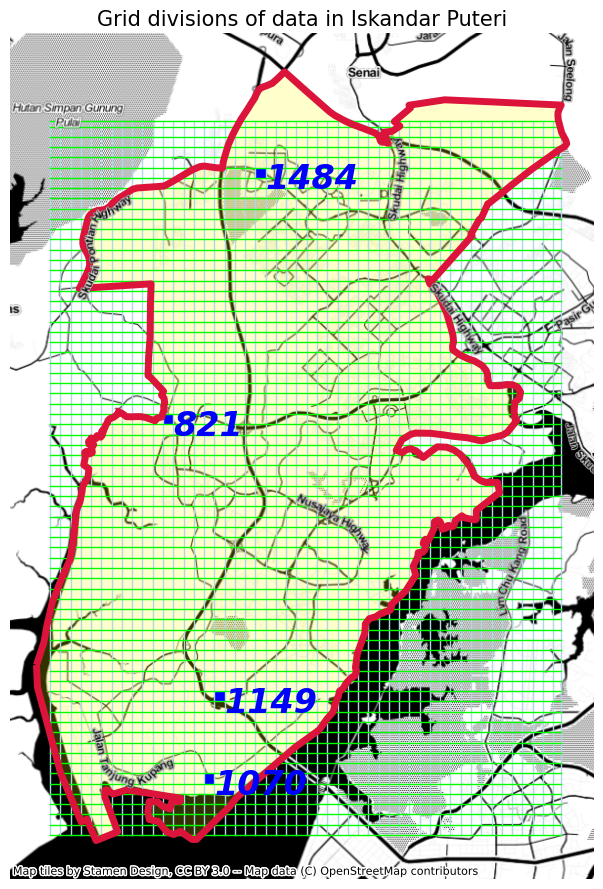

In [30]:
def plot_grid(x_min,x_max,y_min,y_max,size,ax):
    x,y = x_min,y_min
    # vertical
    while x < x_max:
        ax.plot([x,x],[y_min,y_max],c='lightblue',linewidth=1)
        x += size
    ax.plot([x_max,x_max],[y_min,y_max],c='lightblue',linewidth=1)
    # horizontal
    while y < y_max:
        ax.plot([x_min,x_max],[y,y],c='lime',linewidth=1)
        y += size
    ax.plot([x_min,x_max],[y_max,y_max],c='lime',linewidth=1)
    return ax

grid_size = 400 # 400 meters x 400 meters

fig, ax = plt.subplots(figsize=(7,9))
# plot grid
ax = plot_grid(x_min,x_max,y_min,y_max,grid_size,ax)

# draw iskandar puter boundary
area.boundary.to_crs('EPSG:32648').plot(ax=ax,edgecolor='crimson',linewidth=5)
area.to_crs('EPSG:32648').plot(ax=ax,color='yellow',alpha=0.2)

# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerBackground, crs='EPSG:32648')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLabels, crs='EPSG:32648')

ax.axis("off")
# selected box for examples
boxids = [1484,821,1149,1070]
for boxid in boxids:
    shape = Rectangle((bbox.iloc[boxid]['x_min'], bbox.iloc[boxid]['y_min']),
            width=grid_size, height=grid_size,facecolor='blue')
    ax.add_patch(shape)
    ax.text(
        bbox.iloc[boxid]['x_min']+grid_size,
        bbox.iloc[boxid]['y_min']-grid_size,
        boxid, fontsize=24,c='blue',
        fontweight='bold',fontstyle='italic')
plt.title("Grid divisions of data in Iskandar Puteri",fontsize=15)
plt.tight_layout()
plt.show()

### Examples of Counted terms
Example Boxes: 1148, 821, 1149, 1070

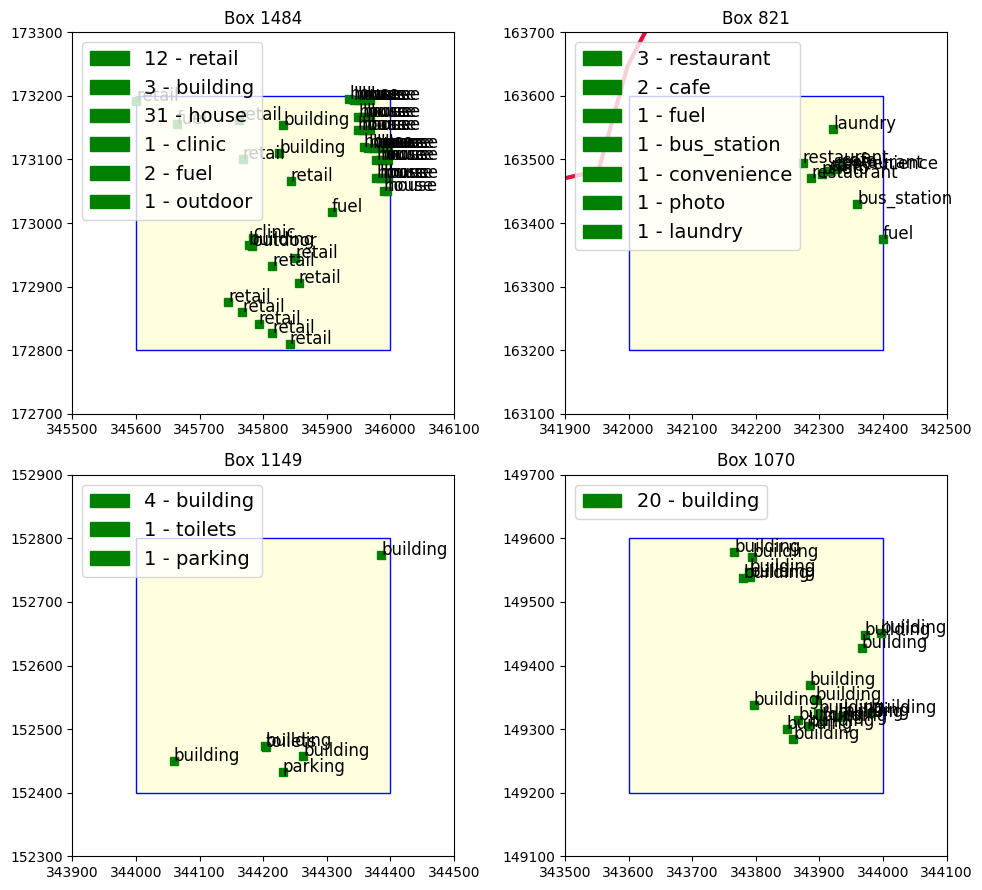

In [31]:
margin = 100
fig, ax = plt.subplots(2,2,figsize=(10,9))
for i,boxid in enumerate(boxids):
    row,col = i//2,i%2
    # basemap
    area.boundary.to_crs('EPSG:32648').plot(ax=ax[row,col],edgecolor='crimson',linewidth=3)
    # draw box
    r = bbox.iloc[boxid]
    shape = Rectangle((r['x_min'], r['y_min']),
            width=grid_size, height=grid_size,
            edgecolor='blue', alpha=1,
            facecolor='lightyellow',fill=True)
    ax[row,col].add_patch(shape)
    ax[row,col].set_ylim(bottom=r['y_min']-margin,top=r['y_min']+grid_size+margin)
    ax[row,col].set_xlim(left=r['x_min']-margin,right=r['x_min']+grid_size+margin)
    ax[row,col].set_title(f"Box {boxid}")

    # draw points
    ent_ids = r['ent_idx']
    for _,(term,cent) in entity[['term','centroid']].iloc[ent_ids].iterrows():
        ax[row,col].plot(cent.xy[0][0],cent.xy[1][0],'gs')
        ax[row,col].text(cent.xy[0][0],cent.xy[1][0] , term, fontsize=12)
    # draw term counts
    ldict = dict(Counter(bbox.iloc[boxid]['ent_term']))
    legend_elements = [Patch(color='green',label=f"{ldict[x]} - {x}") for x in ldict]
    ax[row,col].legend(handles=legend_elements, loc='upper left',fontsize=14)

plt.tight_layout()

# 3. Clustering

In [32]:
# View first 5 rows of features
features.head()

,administrative,apartments,atm,bag,bakery,bank,bar,beauty,bench,beverages,...,university,variety_store,vending_machine,veterinary,warehouse,waste_basket,waste_disposal,water_point,wholesale,wine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# View first 5 bounding boxes data
bbox.head()

,x_min,x_max,y_min,y_max,ent_idx,ent_term,docs
0,337600,338000,147200,147600,[],None,
1,337600,338000,147600,148000,[],None,
2,337600,338000,148000,148400,[],None,
3,337600,338000,148400,148800,[],None,
4,337600,338000,148800,149200,[],None,


## 3A. Grid search for DBSCAN Clustering
- Values of eps: [0.2,0.5,0.8]
- Values of min_samples: [10,20,30]
- Types of scaler : [normalize, min_max_scale, robust_scale]

Grid search resulting in 27 hyperparameters combinations.

Note:
- eps: Two points are considered neighbors if the distance between the two points is below the threshold epsilon.
- min_samples: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples.
- Data Scaling: Scale generally means to change the range of the values.


In [34]:
scaler = [normalize,minmax_scale,robust_scale]
dics = []
for eps in [0.2,0.5,0.8]:
    for ms in [10,20,30]:
        for sc in scaler:
            scaled_f = sc(features)
            cluster = DBSCAN(eps=eps, min_samples=ms).fit(scaled_f)
            # bbox['label'] = cluster.labels_
            dics.append({
                'eps':eps,
                'min_samples':ms,
                'scaling':sc.__name__,
                'clusters':np.unique(cluster.labels_,return_counts=True)[1],
                'labels':cluster.labels_,
                })

### Sorted results of clustering

In [35]:
resdf = pd.DataFrame(dics)
resdf['clusters_count'] = resdf['clusters'].apply(len)
resdf['noise_count'] = resdf['clusters'].apply(lambda x:x[0])
resdf.sort_values('noise_count')

,eps,min_samples,scaling,clusters,labels,clusters_count,noise_count
18,0.8,10,normalize,"[71, 2703, 18, 829]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, -1,...",4,71
21,0.8,20,normalize,"[111, 2703, 807]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 1, -...",3,111
24,0.8,30,normalize,"[143, 2703, 775]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 1, -...",3,143
22,0.8,20,minmax_scale,"[156, 3465]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,156
19,0.8,10,minmax_scale,"[156, 3465]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,156
25,0.8,30,minmax_scale,"[156, 3465]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,156
10,0.5,10,minmax_scale,"[201, 3420]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,201
13,0.5,20,minmax_scale,"[203, 3418]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,203
16,0.5,30,minmax_scale,"[209, 3412]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,209
9,0.5,10,normalize,"[220, 2703, 14, 506, 11, 10, 36, 15, 41, 30, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, -1,...",12,220


## 3B. Select Model
- Selection criteria (defined arbitrarily)
    - Model with 6 total clusters (1 noise cluster + 1 empty cluster + 4 normal clusters)
    - Model with lowest noise count

In [36]:
resdf[resdf['clusters_count'] == 6].sort_values('noise_count',ascending=False)

,eps,min_samples,scaling,clusters,labels,clusters_count,noise_count
15,0.5,30,normalize,"[363, 2703, 399, 82, 40, 34]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 1, -...",6,363


### Assign bounding boxes with labels from selected model
Model no. 15 is selected based on the pre-defined criteria

In [37]:
selected = resdf.iloc[15]
bbox['label'] = selected['labels']
# example of random 5 bounding boxes
bbox.sample(5,random_state=10)

,x_min,x_max,y_min,y_max,ent_idx,ent_term,docs,label
101,338000,338400,159200,159600,[],None,,0
1670,346800,347200,162000,162400,"[5025, 5026, 5028, 5356, 5357, 5358, 5359, 536...","[building, building, building, building, build...",building building building building building b...,1
3440,356800,357200,160000,160400,[],None,,0
1297,344800,345200,154800,155200,[],None,,0
1592,346400,346800,159200,159600,"[3822, 3823, 3824, 3825, 3826, 3827, 3828, 382...","[residential, residential, residential, reside...",residential residential residential residentia...,2


## 3C. Clusters Visualisation
Essentially, each bounding box has a set of coordinates that define its boundaries and a label. The label is associated with a specific color, and the box is drawn as a rectangle using the coordinates and its assigned color.

The color cyan is assigned to noise, and empty boxes are made transparent. The colors green, yellow, pink, and red are respectively assigned to clusters 1, 2, 3, and 4.

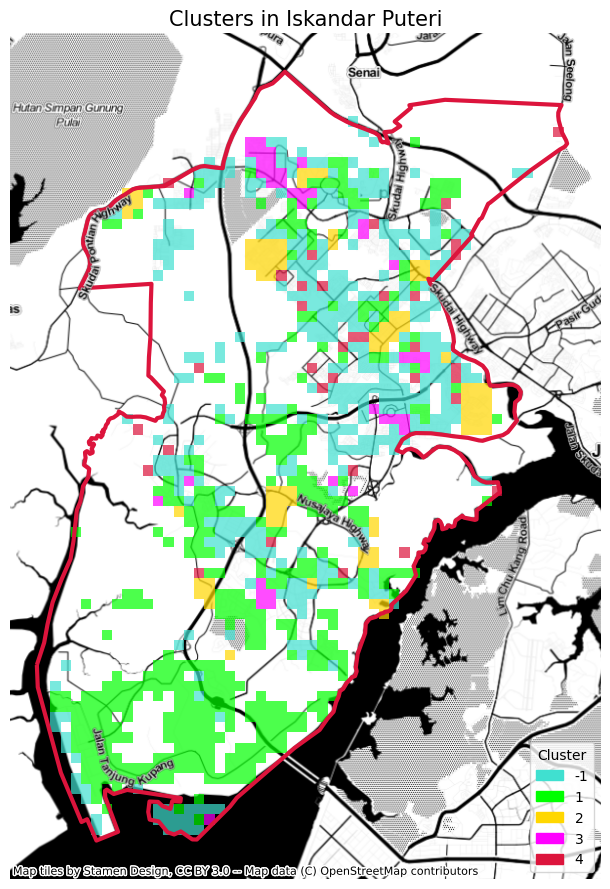

In [38]:
cdict = {
    -1:'turquoise',   # -1 for noise
    0 :'white',    # 0 empty cluster
    1 :'lime',     # 1
    2 :'gold',     # 2
    3 :'fuchsia',  # 3
    4 :'crimson',      # 4
}

fig, ax = plt.subplots(figsize=(7,9))

# draw boxes based on cluster number
for _,row in bbox.iterrows():
    color = cdict[row['label']]
    alpha = 0
    if row['label']:
        alpha = 0.7
    shape = Rectangle((row['x_min'], row['y_min']),
            width=grid_size, height=grid_size,
            facecolor=color, alpha=alpha)

    ax.add_patch(shape)

# draw iskandar puter boundary
area.boundary.to_crs('EPSG:32648').plot(ax=ax,edgecolor='crimson',linewidth=3)

# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerBackground, crs='EPSG:32648')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLabels, crs='EPSG:32648')

# draw custom legend
legend_elements = [Patch(color=cdict[x],label=x) for x in cdict if x != 0]
ax.legend(title="Cluster", handles=legend_elements, loc='lower right')
plt.title("Clusters in Iskandar Puteri",fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# 4. Cluster Interpretation
## 4A. Visualize the terms in the clusters by Word Cloud

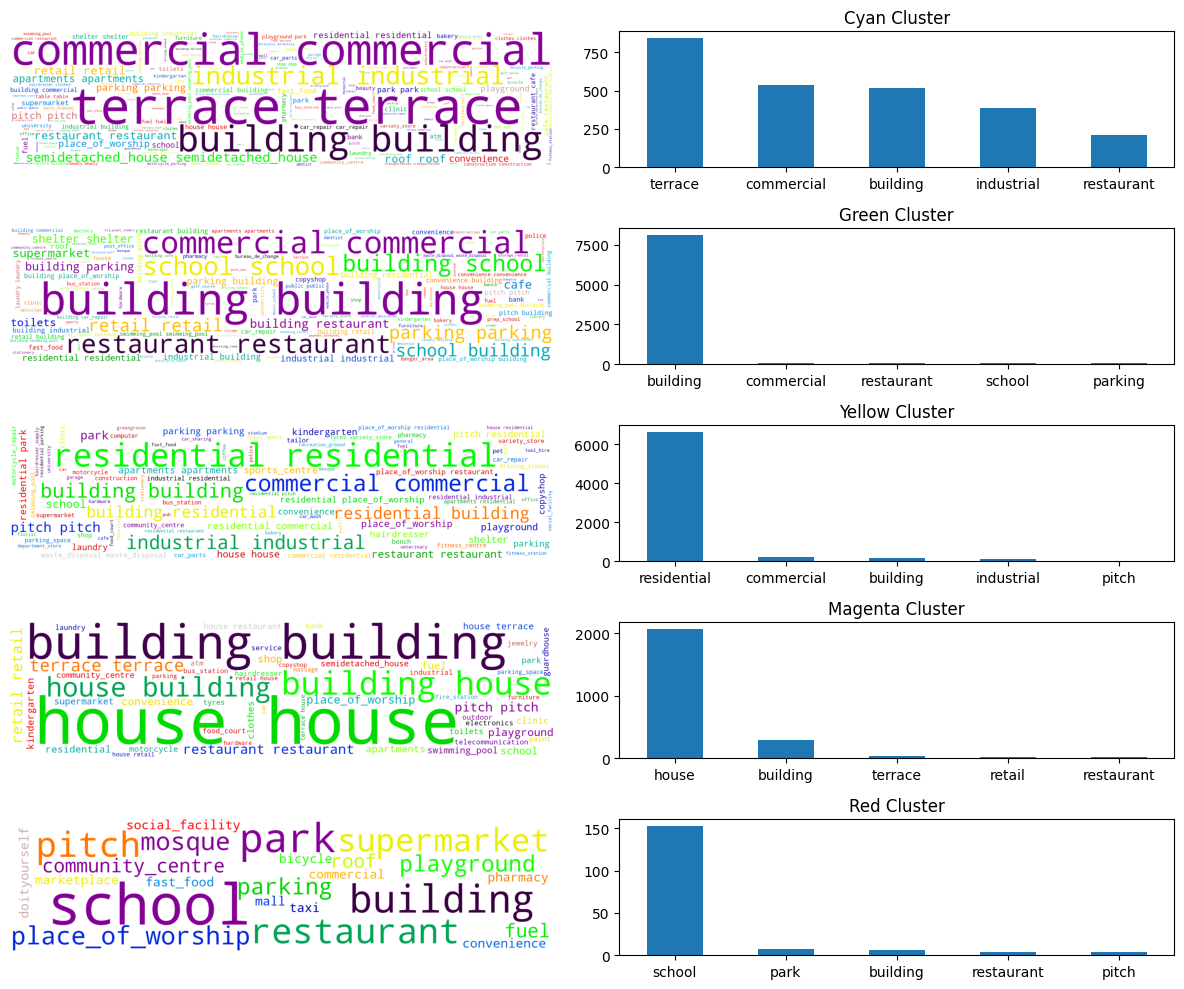

In [39]:
colors =  ["Cyan","Green","Yellow","Magenta","Red"]
from wordcloud import WordCloud
fig, ax = plt.subplots(5,2,figsize=(12,10))
for idx,(i,title) in enumerate(zip([-1,1,2,3,4],colors)):
    # wordcloud
    text = " ".join(bbox[bbox['label'] == i]['docs'].values)
    cloud = WordCloud(width=2000,height=500,background_color='white',
                    colormap='nipy_spectral',relative_scaling=0.3,
                    random_state=42).generate(text)
    ax[idx,0].imshow(cloud)
    # ax[0,0].title(title)
    ax[idx,0].axis("off")
    # barchart if top terms
    (features.iloc[bbox[bbox['label'] == i]['ent_term'].index]
        .sum(axis=0)
        .sort_values(ascending=False)[:5]
        .plot(kind='bar',ax=ax[idx,1],rot=0))
    ax[idx,1].set_title(title + " Cluster")
plt.tight_layout()
plt.show()

## 4B. Observe Pattern of Development
Research Question: What are the hidden patterns of development in Iskandar Puteri?

It can be challenging to identify patterns in the initial input data due to the uneven distribution of entities throughout the map. However, using clustering techniques can reveal previously hidden patterns in the area.
<div>
<img src="img/before.png" width="300"/>
<img src="img/after.png" width="300"/>
</div>
<em>Left: Initial input data. Right: Clusters</em>

Based on the analysis of word clouds and a predominant word count, it was determined that the colour cyan represents mixed development or is detected as noise, green represents undefined buildings, yellow represents residential structures, magenta represents houses, and red represents schools.

Upon initial examination, the most striking pattern that emerges is the regularity of the yellow clusters representing residential structures. A grid-like development is observed along a northeast-to-southwest direction and its perpendicular. Notably, the yellow clusters are surrounded mainly by mixed developments. Similarly, the magenta cluster, which represents houses, has a regular pattern in the same direction.  Additionally, there are typically several red clusters, which represent schools, located in proximity to the yellow clusters.

Interestingly, this pattern does not align directly with the general direction of the roads. Furthermore, large green clusters can be observed, representing undefined buildings. This may indicate that these areas are currently undeveloped and have significant potential for future development.
<div>
<img src="img/Slide6.PNG" width="800"/>
</div>

# 5. Conclusion

In conclusion, our research aimed to uncover hidden development patterns in Iskandar Puteri using clustering algorithms on geospatial data. The analysis revealed regular grid-like patterns for residential structures and houses, mainly surrounded by mixed developments. Schools were also observed in proximity to the residential areas. Large green clusters representing undefined buildings were observed, indicating the potential for future growth in these areas. It is interesting to note that the pattern does not align directly with the general direction of the roads.

Geospatial analysis is a powerful tool as it provides an easy way to visualise and analyse data in a geographical context. It allowed us to successfully answer our research question by uncovering these hidden patterns. However, it is essential to note that the reasons behind these patterns can be determined with additional information and research. The obvious pattern uncovered may be deliberate or purely coincidence. Based on the results, further research and analysis are recommended to understand the reasons behind the patterns and to explore the potential of undeveloped areas for future development. Using clustering algorithms on geospatial data can be a valuable tool for planning and decision-making in Iskandar Puteri.

### Challenges

Installing GeoPandas on a Windows machine requires following specific steps to ensure successful installation (if using non-conda environment). For this purpose the python version need to be 3.10. There are three packages need to be installed using precompiles wheel downloaded from ... website. Specific version are... subseqently the other installation can be done using normal pip install.